# Age recognition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
import cv2


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers

from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.compat.v1.keras.backend import clear_session
from tensorflow.compat.v1.keras.backend import get_session

from tensorflow.keras.models import Model
import tensorflow.keras.models as M
from tensorflow.keras.layers import *
import tensorflow.keras.layers as L

from tensorflow.keras.applications.xception import Xception
from keras import backend as K

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

import PIL
from PIL import Image, ImageOps, ImageFilter

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 4

#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['facial-age', 'test-single-image', 'face-datafarme', 'test-image-2']
Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [2]:
!pip freeze > requirements.txt

In [3]:
EPOCHS               = 20 # для начала поставим эпох обучения
BATCH_SIZE           = 32 # если сеть большая, уменьшаем batch, иначе не влезет в память на GPU
LR                   = 1e-4 # learning rate
VAL_SPLIT            = 0.2 # сколько процентов выделяем на валидацию

CLASS_NUM            = 100 # не будем тут задавать количество классов, так как у нас две модели и в каждой разное количество классов
IMG_SIZE             = 100 # размер картинки
IMG_CHANNELS         = 3 # количество каналов (3, если картинка цветная)
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

data_age = '../input/facial-age/face_age/'

PATH = "../working/"

# две картинки для тестирования модели
sin_im_path = '../input/facial-age/face_age/015/1039.png'
test_sin_im_path = '../input/test-single-image/test_image.png'

In [4]:
os.makedirs(PATH,exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

### EDA

In [5]:
# Посмотрим на отдельные фотографии

def see_sample_images(age, number_of_images):
    plt.figure(figsize=(5,5))
    age_folder = data_age + age
    images = os.listdir(age_folder)[:number_of_images]
    for i in range(number_of_images):
        file = plt.imread(age_folder +'/'+ images[i])
        print('Data Type:',file.dtype)
        print('Data Shape:',file.shape)
        print('Min: %.3f, Max: %.3f' % (file.min(), file.max()))
        plt.subplot(number_of_images/2,2,i+1)
        plt.imshow(file)

Data Type: float32
Data Shape: (200, 200, 3)
Min: 0.016, Max: 0.988
Data Type: float32
Data Shape: (200, 200, 3)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


Min: 0.000, Max: 1.000
Data Type: float32
Data Shape: (200, 200, 3)
Min: 0.016, Max: 1.000
Data Type: float32
Data Shape: (200, 200, 3)
Min: 0.000, Max: 0.976


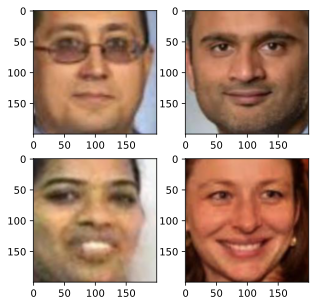

In [6]:
see_sample_images('035', 4)

Размер тренировочных каритнок - 200х200

In [7]:
X = []
Y = []

for folder_name,_,filenames in os.walk(data_age):
    if folder_name !="face_age" and folder_name != 'Data':
        for file in filenames:
            file_path = folder_name +"/"+ file
            im = Image.open(file_path)
            im = im.convert('RGB')
            im = im.resize((100, 100))
            X.append(np.array(im))
            Y.append(int(folder_name[-3:]))
    else:
        pass
    
sys.getsizeof(X)

158208

In [8]:
X = np.array(X)
X = X.astype('float32')
#X /= 255.0

Y = np.array(Y)

print(f'Min: {X.min()}, Max: {X.max()}')

Min: 0.0, Max: 255.0


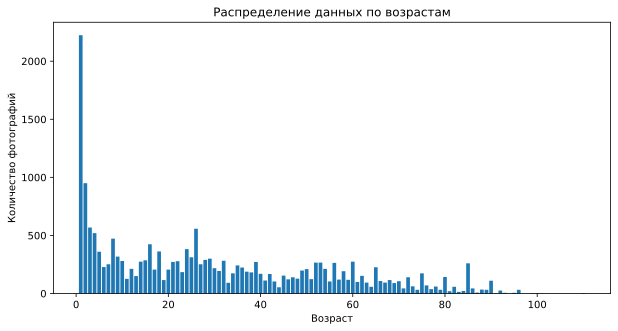

In [9]:
# Распределение данных

age_count = pd.Series(Y).value_counts()

plt.figure(figsize=(10,5))

plt.bar(age_count.index, age_count.values)
#plt.plot(epochs, val_mae, 'g', label='Validation mae')
plt.title('Распределение данных по возрастам')
plt.ylabel('Количество фотографий')
plt.xlabel('Возраст')
#plt.legend()


plt.show()

### Augmentation and preparation

In [10]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor
    
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-eko6u11h
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-eko6u11h
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29561 sha256=d4dae3647293019b3a31d360d732f1a6936c9df69728882a6898018d0561a2c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ylaacee/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [11]:
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.OneOf([
        A.CenterCrop(height=100, width=80),
        A.CenterCrop(height=80, width=100)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

In [12]:
# используем для аугментаций библиотеку albumentations

train_datagen = ImageDataAugmentor(
                        #rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                      )

test_datagen = ImageDataGenerator(
    #rescale=1./255
)

## Model 1 - age

### Making age model

In [13]:
# будем строить модель на основе MobileNet
from keras.applications.mobilenet import MobileNet

In [14]:
checkpoint = ModelCheckpoint('best_model_a.hdf5', 
                             monitor = ['val_loss'], 
                             verbose = 1,
                             mode = 'max')

earlystop = EarlyStopping(monitor = 'val_loss',
                          patience = 5,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.15,
                              patience=3,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')

callbacks_list = [checkpoint, earlystop, reduce_lr]

In [15]:
# Инициализация модели
def make_model(non_train_layers):
    base_model = MobileNet(weights='imagenet', 
                                include_top=False, 
                                input_shape = input_shape)
    
    base_model.trainable = True
    
    fine_tune_at = round((len(base_model.layers)*non_train_layers)) # количество слоев, которые не будут обучаться

    # замораживаем часть слоев
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False

    model = M.Sequential()
    model.add(L.BatchNormalization(input_shape = input_shape))
    model.add(base_model)
    model.add(L.BatchNormalization())
    model.add(L.GlobalAveragePooling2D())
    model.add(L.Dropout(0.3))
    model.add(L.Dense(1, activation='linear'))
    return model

# Построение графика
def plot_history(history):
    plt.figure(figsize=(10,5))
    mae = history.history['mean_absolute_error'] 
    val_mae = history.history['val_mean_absolute_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(mae))

    plt.plot(epochs, mae, 'b', label='Training mae')
    plt.plot(epochs, val_mae, 'g', label='Validation mae')
    plt.title('Training and validation mean_absolute_error')
    plt.legend()


    plt.figure(figsize=(10,5))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [16]:
# базовая модель

base_model = MobileNet(weights='imagenet', 
                                include_top=False, 
                                input_shape = input_shape)

17227776/17225924 [==============================] - 0s 0us/step


In [17]:
# Задаем 4 фолда для кросс-валидации
folds = 4
kfold = KFold(n_splits=folds, shuffle=True)

In [18]:
mae_list = [] # будем сохраниять mae по фолдам

for fold, (train_index, test_index) in enumerate(kfold.split(X, Y)):
    print('-'*20)
    print(f'Fold - {fold+1}')
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)
    
    model_a = make_model(0) # обучаем сразу 100% слоев
    
    model_a.compile(loss='mean_absolute_error', 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["mean_absolute_error"])
    
    history = model_a.fit(
                        train_datagen.flow(X_train/255,Y_train,
                             batch_size = 16), # use augmented images
                        validation_data = (X_val/255,Y_val),
                        steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
                        epochs = 30,
                        callbacks = callbacks_list
                        )
    scores = model_a.evaluate(X_test/255, Y_test, batch_size=128, verbose=1)
    mae_list.append(scores)
    
    K.clear_session()
    print(f"MAE: {scores[1]}")

--------------------
Fold - 1
Epoch 1/30
458/458 [==============================] - 20s 31ms/step - loss: 28.7738 - mean_absolute_error: 28.7738 - val_loss: 24.2753 - val_mean_absolute_error: 24.2753

Epoch 00001: saving model to best_model_a.hdf5
Epoch 2/30
458/458 [==============================] - 13s 27ms/step - loss: 25.9462 - mean_absolute_error: 25.9462 - val_loss: 18.0565 - val_mean_absolute_error: 18.0565

Epoch 00002: saving model to best_model_a.hdf5
Epoch 3/30
458/458 [==============================] - 12s 27ms/step - loss: 21.7485 - mean_absolute_error: 21.7485 - val_loss: 7.9413 - val_mean_absolute_error: 7.9413

Epoch 00003: saving model to best_model_a.hdf5
Epoch 4/30
458/458 [==============================] - 12s 27ms/step - loss: 17.2024 - mean_absolute_error: 17.2024 - val_loss: 6.9430 - val_mean_absolute_error: 6.9430

Epoch 00004: saving model to best_model_a.hdf5
Epoch 5/30
458/458 [==============================] - 12s 26ms/step - loss: 14.3459 - mean_absolute_er

In [19]:
print(f'среднее mae по {folds} фолдам = ',np.mean(mae_list))
print('дисперсия mae = ',np.var(mae_list))

среднее mae по 4 фолдам =  3.8504083156585693
дисперсия mae =  0.005572320942889064


In [20]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model_a.save('../working/model_a_regression')
model_a.save('../working/model_a_regression_last_1.hdf5')
model_a.load_weights('best_model_a.hdf5')

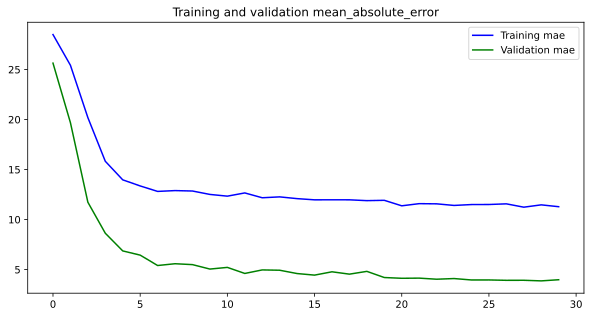

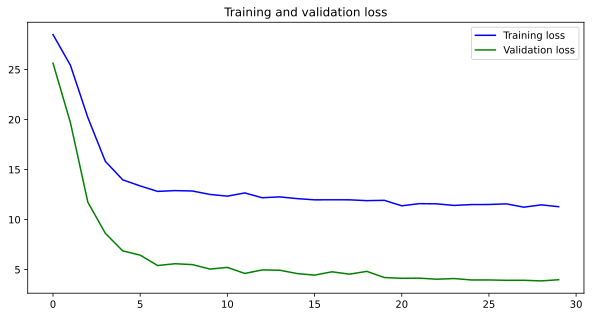

In [21]:
plot_history(history)

## Test on single image

для того, чтобы модель работала в проде, нужно протестить ее на предсказание отдельных картинок

In [22]:
# модуль, который буду использовать для обнаружения лица на изображении
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 30 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=8286ad7c35c1a9f39d48e94a21348a205016e96b2a305a2136adffdef1126989
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [23]:
import face_recognition
from skimage import transform

#### 1. Картинка внешняя

In [24]:
load_im = face_recognition.load_image_file('../input/test-image-2/2021-07-1819.06.28.png')
load_im.shape

(988, 1404, 3)

In [25]:
face_locations = face_recognition.face_locations(load_im) # определяем лица

top, right, bottom, left = face_locations[0]
face1 = load_im[top-50:bottom+50, left-50:right+50] # забираем изображение лица

In [26]:
face1[0][0]

array([142, 143, 138], dtype=uint8)

(421, 421, 3)


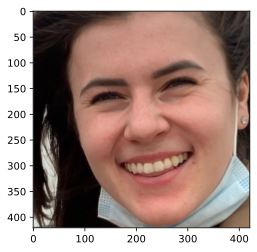

In [27]:
print(face1.shape)
plt.imshow(face1)

Как видим, данные не нормализованы, размер отличается от того, на который заточена сеть

In [28]:
face1 = face1/255.# нормализуем
face1 = transform.resize(face1, (100, 100, 3)) # ресайзим в целевой размер
face1 = np.expand_dims(face1, axis=0) # добавляем батч
print(face1.shape)

(1, 100, 100, 3)


In [29]:
# Смотрим предикты моделей - загруженной и обученной
#print('результат загруженной модели - ',load_model_a.predict(face1)[0][0])
print('результат обученной модели - ',model_a.predict(face1)[0][0])

результат обученной модели -  40.10992
